In [8]:
import sys, os
import numpy as np
from pyhdf.SD import SD
import pandas as pd
from datetime import datetime, time, timedelta
import re
import time
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import pearsonr

from functions import *
# Path and Variable declarations
# External harddrive path
file_ext= "D:\\NASA_AIRS"
file_path_plots=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\Plots"
# Internal testing folder
#file_ext=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\AIRS"
#sort file list

folder_year_list=sorted(os.listdir(file_ext))


# Coordinates for TECQ stations
CAMS49 = [31.6676,-106.288]
CAMS1028 = [33.5856, -101.78]


In [10]:
# Create a dataframe for the 2019 to 2021 period for radial measurements
date_index = pd.date_range(start='2019-01-01', end='2021-12-31', freq='D')
time_of_day = pd.date_range(start='2023-01-01', periods=24, freq='H').time
dust_score_stats_CAMS49 = pd.DataFrame(index=date_index, columns=time_of_day)

dust_score_pm_matches_cams49=[['PM', 'dust_score']]
dust_score_pm_matches_max_cams49=[['PM', 'dust_score']]
dust_score_pm_matches_cams1028=[['PM', 'dust_score']]
dust_score_pm_matches_max_cams1028=[['PM', 'dust_score']]


for year in folder_year_list:
    
    file_path_ext=os.path.join(file_ext,year)
    file_list=sorted(os.listdir(os.path.join(file_ext,file_path_ext)))[1:]
    print("Opening folder:", file_path_ext)
    dust_score_pm_matches_cams49.append([year, year])
    dust_score_pm_matches_max_cams49.append([year, year])
    dust_score_pm_matches_cams1028.append([year, year])
    dust_score_pm_matches_max_cams1028.append([year, year])
    
    file_name_cams49=f'CAMS49_{year}.xlsx'
    file_name_cams1028=f'CAMS1028_{year}.xlsx'
    tecq_cams49=read_xlsx_tecq(file_name_cams49)
    tecq_cams1028=read_xlsx_tecq(file_name_cams1028)

    last_ending_time_cams49=datetime(1900,1,1)
    
    for file in file_list:
        start_time=time.time()
        file_path=os.path.join(file_path_ext,file)
        print("Opening file:", file_path)
        
        try:
            hdf_file = SD(file_path)
    
            # Select dust_score, lat and long     
            dust_score=hdf_file.select('dust_score')[:]
            long=hdf_file.select('Longitude')[:]
            lat=hdf_file.select('Latitude')[:]
            coords=coordinates(lat,long)
            # Find timestamp of production
            global_attributes = hdf_file.attributes()
            # Get raw productiondatetime from hdf file
            datetime_hdf_raw=find_rangedatetime(global_attributes)

            # Convert raw string into datetime object
            datetime_converted=datetime.strptime(datetime_hdf_raw,"%Y-%m-%dT%H:%M:%S.%fZ")

            # Round time from converted hdf datetime object to nearest hour 
            datetime_rounded_time=round_nearest_hour(datetime_converted)

                
            print("UTC: ",datetime_rounded_time)
            # Convert UTC to MST (only valid for CAMS49)
            datetime_rounded_time_mst=datetime_rounded_time-timedelta(hours=7)
            datetime_rounded_time_cst=datetime_rounded_time-timedelta(hours=6)
            print("MST: ",datetime_rounded_time_mst)
            print("CST: ",datetime_rounded_time_cst)

            # Convert datetime object (date part only) into string
            datetime_converted_str_mst=datetime_rounded_time_mst.date().strftime("%Y-%m-%d")
            datetime_converted_str_cst=datetime_rounded_time_cst.date().strftime("%Y-%m-%d")
            
            # Use the date string to find the matching date row in the TECQ file
            tecq_date_found_cams49=tecq_cams49.loc[datetime_converted_str_mst]
            tecq_date_found_cams1028=tecq_cams1028.loc[datetime_converted_str_cst]
            
            # Make an array of an hour before and after the flyby's rounded hour
            datetime_range_mst=[(datetime_rounded_time_mst-timedelta(hours=1)).time(), (datetime_rounded_time_mst.time()), (datetime_rounded_time_mst+timedelta(hours=1)).time()]
            datetime_range_cst=[(datetime_rounded_time_cst-timedelta(hours=1)).time(), (datetime_rounded_time_cst.time()), (datetime_rounded_time_cst+timedelta(hours=1)).time()]
            # Find the mean PM concentration at time of satellite flyby at TECQ station
            tecq_pm_hourmean_cams49=np.mean(tecq_date_found_cams49[datetime_range_mst])
            tecq_pm_hourmean_cams1028=np.mean(tecq_date_found_cams1028[datetime_range_cst])
            # Find the max daily PM at TECQ station   
            tecq_pm_daymax_cams49=np.max(tecq_date_found_cams49)
            tecq_pm_daymax_cams1028=np.max(tecq_date_found_cams1028)
            print("Mean 3hour PM CAMS49: ", tecq_pm_hourmean_cams49)
            print("Max Daily PM CAMS49: ", tecq_pm_daymax_cams49)
            print("Mean 3hour PM CAMS49: ", tecq_pm_hourmean_cams1028)
            print("Max Daily PM CAMS49: ", tecq_pm_daymax_cams1028)
                
            # Match coordinates between satellite flyby and TECQ stations
            matched_cams49_coords=match_coords(coords, CAMS49,0.05)
            matched_cams1028_coords=match_coords(coords, CAMS1028,0.05)
            # Create boolean mask for each array of matched coordinates
            mask_cams49=create_mask(matched_cams49_coords)
            mask_cams1028=create_mask(matched_cams1028_coords)
            # Check if any mask is only False boolean values
            anymatches1028=np.any(mask_cams1028 == True, axis=1)
            anymatches49=np.any(mask_cams49 == True, axis=1)
            '''
            # Do not process coordinates if they do not match for either TECQ station
            if np.any(anymatches1028 == True, axis=0):
                print("Found matching coordinates for CAMS1028...")
                dust_score_masked_cams1028=dust_score[mask_cams1028]
                dust_score_mean_cams1028=np.mean(dust_score_masked_cams1028)
                dust_score_max_cams1028=np.max(dust_score_masked_cams1028)
                print("Mean dust_score CAMS1028: ",dust_score_mean_cams1028)
                print("Max dust_score CAMS1028: ",dust_score_max_cams1028)
                dust_score_pm_matches_cams1028.append([tecq_pm_hourmean_cams1028, dust_score_mean_cams1028])
                dust_score_pm_matches_max_cams1028.append([tecq_pm_daymax_cams1028, dust_score_max_cams1028])
            else:
                print("No matching coordinates found for CAMS1028.")

            if np.any(anymatches49 == True, axis=0):
                print("Found matching coordinates for CAMS49...")
                dust_score_masked_cams49=dust_score[mask_cams49]
                dust_score_mean_cams49=np.mean(dust_score_masked_cams49)
                dust_score_max_cams49=np.max(dust_score_masked_cams49)
                print("Mean dust_score CAMS49: ",dust_score_mean_cams49)
                print("Max dust_score CAMS49: ",dust_score_max_cams49)               
                dust_score_pm_matches_cams49.append([tecq_pm_hourmean_cams49, dust_score_mean_cams49])
                dust_score_pm_matches_max_cams49.append([tecq_pm_daymax_cams49, dust_score_max_cams49])
            else:
                print("No matching coordinates found for CAMS49.")
            '''
            
            avg_windspd_cams1028=17
            avg_windspd_cams49=14
            windspd_radii_cams1028=np.arange(1,12*avg_windspd_cams1028,avg_windspd_cams1028)
            #Draw circle every 2 hours for 12 hours, until next satellite obesrvation (which could be on the same or the next day)
            windspd_radii_cams49=np.arange(1,12*avg_windspd_cams49,avg_windspd_cams49*2)
            print(windspd_radii_cams49)
            #for radius=0 find mean/mode/median as close as possible to cams station
            coords_reshaped=np.reshape(coords,(coords.shape[0]*coords.shape[1],2))
            observation_starting_time_cams49=datetime_rounded_time_mst
            print("Time of satellite data capture: ", observation_starting_time_cams49)
            for elem in range(len(windspd_radii_cams49)):
                if last_ending_time_cams49>=observation_starting_time_cams49:
                    print("Warning: datetime overlap!")
                
                inner_radius = windspd_radii_cams49[elem]  # Inner circle radius in miles
                #Outer radius will be the distance dust could have spread away from CAMS49 coordinates in 2 hours based on avg windspeed
                outer_radius = windspd_radii_cams49[elem]+avg_windspd_cams49*2  # Outer circle radius in miles doubled since we are interested in change every 2 hours
                print(f"Looking for points between a circle of diameter {outer_radius} and a circle of diameter {inner_radius} miles")
                print("Hour of dust movement: ", observation_starting_time_cams49)
                # Points inside the first circle
                inside_points = points_inside_circle(CAMS49, inner_radius, coords_reshaped)
                
                if len(inside_points)!=0:
                    print("Points found inside first circle, size: ", inside_points.shape)
                    # Points between the circles
                    between_points = points_between_circles(CAMS49, inner_radius, outer_radius, coords_reshaped)
                    if len(between_points)!=0:
                        matched_circle_coords=match_coords_circle(coords, between_points)
                        print("Points found between the two circles, size: ", between_points.shape)
                        #print(between_points)
                        dust_score_mean_between_points=np.mean(dust_score[matched_circle_coords])
                        print(dust_score_mean_between_points)
                        print(observation_starting_time_cams49)
                        print(observation_starting_time_cams49+timedelta(hours=1))
                        dust_score_stats_CAMS49.at[observation_starting_time_cams49.strftime('%Y-%m-%d'), observation_starting_time_cams49.time()]=dust_score_mean_between_points
                        #copy for next hour since circle expands every two hours, so we assume same value.
                        next_hour=observation_starting_time_cams49+timedelta(hours=1)
                        #dust_score_stats_CAMS49.loc[observation_starting_time_cams49.strftime('%Y-%m-%d')].loc[observation_starting_time_cams49.time(),next_hour.time()]=dust_score_mean_between_points
                        print(dust_score_stats_CAMS49.loc[observation_starting_time_cams49.strftime('%Y-%m-%d')][observation_starting_time_cams49.time()])
                        print(dust_score_stats_CAMS49.loc[observation_starting_time_cams49.strftime('%Y-%m-%d')][(observation_starting_time_cams49+timedelta(hours=1)).time()])
                        print(dust_score_stats_CAMS49.loc['2019-01-01'].iloc[0])
                        #draw_grid_plot(CAMS49, coords, inside_points, between_points, file, observation_starting_time_cams49.strftime('%Y-%m-%d  %H:%M:%S'), dust_score, outer_radius)
                        #update the last_ending_time with the latest time written into the dataframe
                        last_ending_time_cams49=observation_starting_time_cams49

                else:
                    print("No points found between circles, drawing next circle...")
                observation_starting_time_cams49+=timedelta(hours=2)
            print("Done")
            #draw_grid_plot(CAMS49, coords, coords[mask_cams49], file, datetime_converted_str_mst, dust_score)
            
            '''
                if dust_score_max>380:
                    print("Found dust_score above 380, printing plot...")
                    draw_grid_plot(coords, coords_masked, file, datetime_hdf_raw, dust_score)
            '''
            
            # Close the HDF4 file
            hdf_file.end()
        except Exception as e:
            print("Error opening file:", file_path)
            print(e)
            print("\n")
        end_time=time.time()
        runtime = end_time - start_time
        print(f"HDF file execution time: {runtime} msec")
        print("\n")
        
    
'''
if __name__ == "__main__":
'''

Opening folder: D:\NASA_AIRS\2019
Opening file: D:\NASA_AIRS\2019\AIRS.2019.01.01.098.L1B.AIRS_Rad.v5.0.23.0.G19001113440.hdf
UTC:  2019-01-01 10:00:00
MST:  2019-01-01 03:00:00
CST:  2019-01-01 04:00:00
Mean 3hour PM CAMS49:  34.53333333333333
Max Daily PM CAMS49:  41.1
Mean 3hour PM CAMS49:  3.3333333333333335
Max Daily PM CAMS49:  7.0
[  1  29  57  85 113 141]
Time of satellite data capture:  2019-01-01 03:00:00
Looking for points between a circle of diameter 29 and a circle of diameter 1 miles
Hour of dust movement:  2019-01-01 03:00:00
No points found between circles, drawing next circle...
Looking for points between a circle of diameter 57 and a circle of diameter 29 miles
Hour of dust movement:  2019-01-01 05:00:00
No points found between circles, drawing next circle...
Looking for points between a circle of diameter 85 and a circle of diameter 57 miles
Hour of dust movement:  2019-01-01 07:00:00
No points found between circles, drawing next circle...
Looking for points between 

C:\Users\Zelda64\miniconda3\envs\cmip6_python\Lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


Error opening file: D:\NASA_AIRS\2021\AIRS.2021.10.04.091.L1B.AIRS_Rad.v5.0.25.0.G21277175818.hdf
Latitude must be in the [-90; 90] range.


HDF file execution time: 4.129904747009277 msec


Opening file: D:\NASA_AIRS\2021\AIRS.2021.10.04.201.L1B.AIRS_Rad.v5.0.25.0.G21278143320.hdf
UTC:  2021-10-04 21:00:00
MST:  2021-10-04 14:00:00
CST:  2021-10-04 15:00:00
Mean 3hour PM CAMS49:  2.1999999999999997
Max Daily PM CAMS49:  10.8
Mean 3hour PM CAMS49:  5.0
Max Daily PM CAMS49:  10.0
[  1  29  57  85 113 141]
Time of satellite data capture:  2021-10-04 14:00:00
Looking for points between a circle of diameter 29 and a circle of diameter 1 miles
Hour of dust movement:  2021-10-04 14:00:00
No points found between circles, drawing next circle...
Looking for points between a circle of diameter 57 and a circle of diameter 29 miles
Hour of dust movement:  2021-10-04 16:00:00
Points found inside first circle, size:  (23, 2)
Points found between the two circles, size:  (71, 2)
46.148148148148145
202

'\nif __name__ == "__main__":\n'

In [8]:
%whos

Variable   Type    Data/Info
----------------------------
value      str     for value in vars().values():\n  print(value)


In [9]:
%whos

Variable   Type    Data/Info
----------------------------
value      str     for value in vars().values():\n  print(value)


In [54]:
print(len(dust_score_pm_matches_cams49))
print(len(dust_score_pm_matches_max_cams49))
print(len(dust_score_pm_matches_cams1028))
print(len(dust_score_pm_matches_max_cams1028))

1730
1730
1713
1713


(22, 2)
(28, 2)


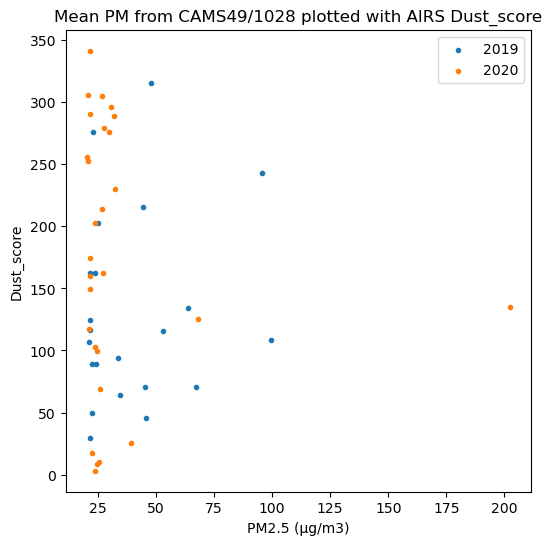

Pearson correlation coefficient 2019 data: 0.147
p-value: 0.513
Pearson correlation coefficient 2020 data: -0.099
p-value: 0.616
Pearson correlation coefficient 2019 and 2020 data: -0.055
p-value: 0.702


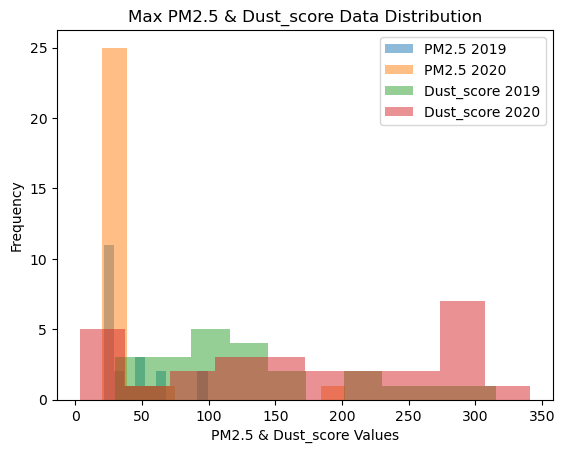

In [140]:
def plot_dust_pm(type: str, threshold_pm: int, threshold_dust_score: int, dust_score_pm_matches_array: list, additional_array: list = None):
    index_year_2019=dust_score_pm_matches_array.index(['2019', '2019'])
    index_year_2020=dust_score_pm_matches_array.index(['2020', '2020'])

    dust_score_pm_matches_2019=np.array(dust_score_pm_matches_array[index_year_2019+1:index_year_2020])
    dust_score_pm_matches_2020=np.array(dust_score_pm_matches_array[index_year_2020+1:])

    if additional_array is not None:
        
        index_year_2019_add=additional_array.index(['2019', '2019'])
        index_year_2020_add=additional_array.index(['2020', '2020'])
        additional_array_2019=np.array(additional_array[index_year_2019_add+1:index_year_2020_add])
        additional_array_2020=np.array(additional_array[index_year_2020_add+1:]) 
        dust_score_pm_matches_2019=np.concatenate((dust_score_pm_matches_2019,additional_array_2019), axis=0)
        dust_score_pm_matches_2020=np.concatenate((dust_score_pm_matches_2020,additional_array_2020), axis=0)

    mask_matches_2019=np.isnan(dust_score_pm_matches_2019).any(axis=1)
    mask_matches_2020=np.isnan(dust_score_pm_matches_2020).any(axis=1)
    
    dust_score_pm_matches_2019=dust_score_pm_matches_2019[~mask_matches_2019]
    dust_score_pm_matches_2020=dust_score_pm_matches_2020[~mask_matches_2020]
    
    dust_score_pm_matches_2020_filtered=dust_score_pm_matches_2020[np.logical_and(dust_score_pm_matches_2020[:,0]>threshold_pm, dust_score_pm_matches_2020[:,1]>threshold_dust_score)]
    dust_score_pm_matches_2019_filtered=dust_score_pm_matches_2019[np.logical_and(dust_score_pm_matches_2019[:,0]>threshold_pm, dust_score_pm_matches_2019[:,1]>threshold_dust_score)]
    print(dust_score_pm_matches_2019_filtered.shape)
    print(dust_score_pm_matches_2020_filtered.shape)
    

    x_pm_2019=dust_score_pm_matches_2019_filtered[:,0]
    y_dust_score_2019=dust_score_pm_matches_2019_filtered[:,1]
    
    x_pm_2020=dust_score_pm_matches_2020_filtered[:,0]
    y_dust_score_2020=dust_score_pm_matches_2020_filtered[:,1]
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.scatter(x_pm_2019,y_dust_score_2019, marker='.', label='2019')
    ax.scatter(x_pm_2020,y_dust_score_2020, marker='.', label='2020')
        
    # Add title and show the plot
    plt.title(f'{type} PM from CAMS49/1028 plotted with AIRS Dust_score')
    plt.xlabel("PM2.5 (µg/m3)")
    plt.ylabel("Dust_score")
    plt.legend()
    plt.show()

    corr_coefficient_2019, p_value_2019 = pearsonr(x_pm_2019, y_dust_score_2019)
    corr_coefficient_2020, p_value_2020 = pearsonr(x_pm_2020, y_dust_score_2020)
    corr_coefficient_comb, p_vale_comb = pearsonr(np.concatenate((x_pm_2019,x_pm_2020)), np.concatenate((y_dust_score_2019,y_dust_score_2020)))
    print("Pearson correlation coefficient 2019 data:", corr_coefficient_2019.round(3))
    print("p-value:", p_value_2019.round(3))
    print("Pearson correlation coefficient 2020 data:", corr_coefficient_2020.round(3))
    print("p-value:", p_value_2020.round(3))
    print("Pearson correlation coefficient 2019 and 2020 data:", corr_coefficient_comb.round(3))
    print("p-value:", p_vale_comb.round(3))

    plt.hist(x_pm_2019, alpha=0.5, label='PM2.5 2019')
    plt.hist(x_pm_2020, alpha=0.5, label='PM2.5 2020')
    plt.hist(y_dust_score_2019, alpha=0.5, label='Dust_score 2019')
    plt.hist(y_dust_score_2020, alpha=0.5, label='Dust_score 2020')
    
    plt.xlabel('PM2.5 & Dust_score Values')
    plt.ylabel('Frequency')
    plt.title('Max PM2.5 & Dust_score Data Distribution')
    
    plt.legend()
        
plot_dust_pm('Mean', 20, 0,dust_score_pm_matches_cams1028,dust_score_pm_matches_cams49)

In [90]:
#ax.set_extent([-115, -85, 15, 40], crs=ccrs.PlateCarree())  # Adjust to focus on a specific region
